# Import lIbraries:

In [8]:
import numpy as np
import pandas as pd
import random
import os
import warnings
# ----------------------
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -------
import cv2
from sklearn.utils import shuffle
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import io
from PIL import Image
import tqdm
import tensorflow as tf

# -----------------
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array

# Data Load:

I have dataset of human brain tumor images and the datset is given by the client as train and test images.
To find better generalize deep liearning model, I  combined all the images together and proceed further analysis:

In [2]:
# Initialize variables to track the global min and max pixel values
global_min = float('inf')
global_max = float('-inf')

In [3]:
# Gathering all train and test togethers
X_Images = []
Y_labels = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

# Train images
for i in labels:
    # Train dir: '/user1/student/mtc/mtc2023/cs2326/Project_Works/Training'
    foldarPath = os.path.join('/user1/student/mtc/mtc2023/cs2326/Project_Works/Training',i)
    for j in os.listdir(foldarPath):
        img = cv2.imread(os.path.join(foldarPath,j))
        if img is not None:
            # Find the min and max of the current image
            min_val = img.min()
            max_val = img.max()

            # Update global min and max
            if min_val < global_min:
                global_min = min_val
            if max_val > global_max:
                global_max = max_val
        else:
            print('Image is empty')
        img = cv2.resize(img,(image_size,image_size))
        X_Images.append(img) 
        Y_labels.append(i)

# Test images
for i in labels:
    # Test dir: '/user1/student/mtc/mtc2023/cs2326/Project_Works/Testing'
    foldarPath = os.path.join('/user1/student/mtc/mtc2023/cs2326/Project_Works/Testing',i)
    for j in os.listdir(foldarPath):
        img = cv2.imread(os.path.join(foldarPath,j))
        if img is not None:
            # Find the min and max of the current image
            min_val = img.min()
            max_val = img.max()

            # Update global min and max
            if min_val < global_min:
                global_min = min_val
            if max_val > global_max:
                global_max = max_val
        else:
            print('Image is empty')
        img = cv2.resize(img,(image_size,image_size))
        X_Images.append(img) 
        Y_labels.append(i)

X_Images = np.array(X_Images)
Y_labels = np.array(Y_labels)

In [4]:
print(f'Maximum pixel value: {global_max}')
print(f'Minimum pixel value: {global_min}')

Maximum pixel value: 255
Minimum pixel value: 0


In [5]:
# Shapes of the X and Y data values that are
print(f"Image set dimesions: {X_Images.shape}")
print(f"Image Labels dimensions: {Y_labels.shape}")

Image set dimesions: (3264, 150, 150, 3)
Image Labels dimensions: (3264,)


# Brain tumopr distribution:

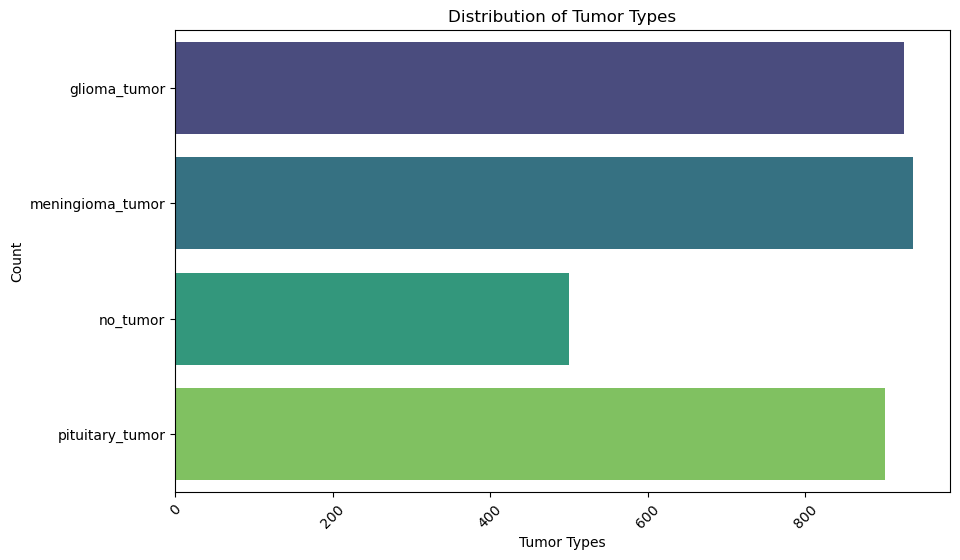

In [8]:
warnings.filterwarnings('ignore')
#Plot using Seaborn's countplot with 'viridis' palette
plt.figure(figsize=(10, 6))
sns.countplot(y=Y_labels, palette='viridis')  # Use data frame with hue
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.xlabel('Tumor Types')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.title('Distribution of Tumor Types')  # Title of the plot
plt.show()

In [6]:
# Counts for each types of tumor:
from collections import  Counter
pd.DataFrame(list(Counter(Y_labels).items()), columns=['Class', 'Count'])

,Class,Count
0,glioma_tumor,926
1,meningioma_tumor,937
2,no_tumor,500
3,pituitary_tumor,901


In [9]:
# Image dimensions
image_size = (150, 150)  
# Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=30,      # Randomly rotate images in the range (0-30 degrees)
    width_shift_range=0.2,  # Randomly translate images horizontally
    height_shift_range=0.2, # Randomly translate images vertically
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom inside pictures
    horizontal_flip=True,   # Randomly flip images
    fill_mode='nearest'     # Fill mode for newly created pixels
)

# Step 1: Filter the images and labels for 'no_tumor' class
no_tumor_images = [X_Images[i] for i in range(len(Y_labels)) if Y_labels[i] == 'no_tumor']

# Step 2: Randomly select 400 images from the filtered set
num_images_to_select = 400
selected_images = random.sample(no_tumor_images, num_images_to_select)

# Step 3: Generate augmented images
augmented_images = []
augmented_labels = []

for img in selected_images:
    # img = img_to_array(img)  # Convert to numpy array if not already
    img = img.reshape((1,) + img.shape)  # Reshape for data generator (1, height, width, channels)
    
    # Generate one augmented image per original image
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))  # Convert back to uint8 format
        augmented_labels.append('no_tumor')  # Append corresponding label
        
        break  # Only generate one augmented image per original image

# Step 4: Add the augmented images and labels back into the dataset
X_images = np.concatenate((X_Images, np.array(augmented_images)))
Y_labels = np.concatenate((Y_labels, np.array(augmented_labels)))

print(f"Augmented {len(augmented_images)} images and added them to the dataset.")
print(f"New dataset size: {len(X_images)} images, {len(Y_labels)} labels.")


Augmented 400 images and added them to the dataset.
New dataset size: 3664 images, 3664 labels.


# Augmented dataset distribution:

In [10]:
pd.DataFrame(list(Counter(Y_labels).items()), columns=['Class', 'Count'])

,Class,Count
0,glioma_tumor,926
1,meningioma_tumor,937
2,no_tumor,900
3,pituitary_tumor,901


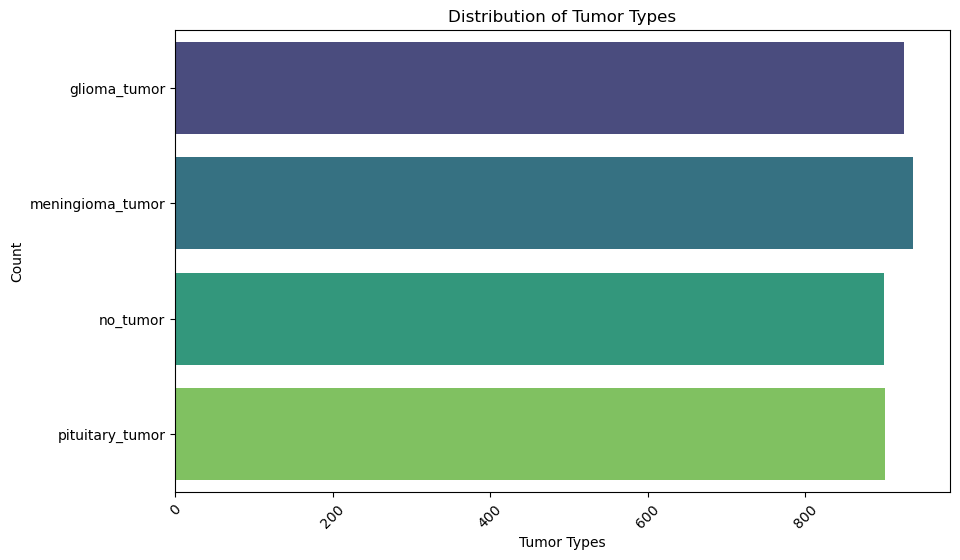

In [12]:
warnings.filterwarnings('ignore')
#Plot using Seaborn's countplot with 'viridis' palette
plt.figure(figsize=(10, 6))
sns.countplot(y=Y_labels, palette='viridis')  # Use data frame with hue
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.xlabel('Tumor Types')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.title('Distribution of Tumor Types')  # Title of the plot
plt.show()

In [14]:
# Shuflling the dataset
X_New_Images,Y_New_labels = shuffle(X_images,Y_labels,random_state=101)


# Splitting the dataset:

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_New_Images,Y_New_labels,test_size=0.2,stratify=Y_labels,random_state=101)

print(f'Train set distribution: {Counter(y_train)}')
print(f'Test set distribution: {Counter(y_test)}')

Train set distribution: Counter({'meningioma_tumor': 755, 'pituitary_tumor': 730, 'glioma_tumor': 727, 'no_tumor': 719})
Test set distribution: Counter({'glioma_tumor': 199, 'meningioma_tumor': 182, 'no_tumor': 181, 'pituitary_tumor': 171})


# Convert categorical to numerical:

In [20]:
# Train labels convertion

# Convert string labels to integer labels
y_train_integer = [labels.index(i) for i in y_train] 

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train_integer,num_classes=4) 

# Test labels convertion
# Convert string labels to integer labels
y_test_integer = [labels.index(i) for i in y_test] 
# One-hot encoding
y_test = tf.keras.utils.to_categorical(y_test_integer,num_classes=4)


# Define CNN Model:

In [23]:
# Initialize CNN neural network
model = Sequential()

# Block:1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25)) 

# Block:2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.25)) 
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block:3
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block:4
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block:5
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))

# Output Block:
model.add(Dense(4,activation='softmax'))


# Model Summary:

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 69, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,447,044 (16.96 MB)

 Trainable params: 4,447,044 (16.96 MB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation:

In [25]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.0001

# Create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)


In [26]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


# Model fitting and history:

In [27]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.2781 - loss: 2.8762 - val_accuracy: 0.4447 - val_loss: 1.3511
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3650 - loss: 1.3077 - val_accuracy: 0.5034 - val_loss: 1.2163
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5228 - loss: 1.1217 - val_accuracy: 0.5307 - val_loss: 1.1234
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5742 - loss: 1.0558 - val_accuracy: 0.5416 - val_loss: 1.0857
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5980 - loss: 0.9818 - val_accuracy: 0.6057 - val_loss: 1.0750
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6020 - loss: 0.9412 - val_accuracy: 0.6098 - val_loss: 0.9786
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6408 - loss: 0.8620 - val_accuracy: 0.7026 - val_loss: 0.8471
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6767 - loss: 0.7847 - val_accuracy: 0.7217 - v

In [149]:
# Save the model in Keras format
model.save('BrainTumorCNNClassifier.keras')


# Accuracy Plots & Loss Plots:

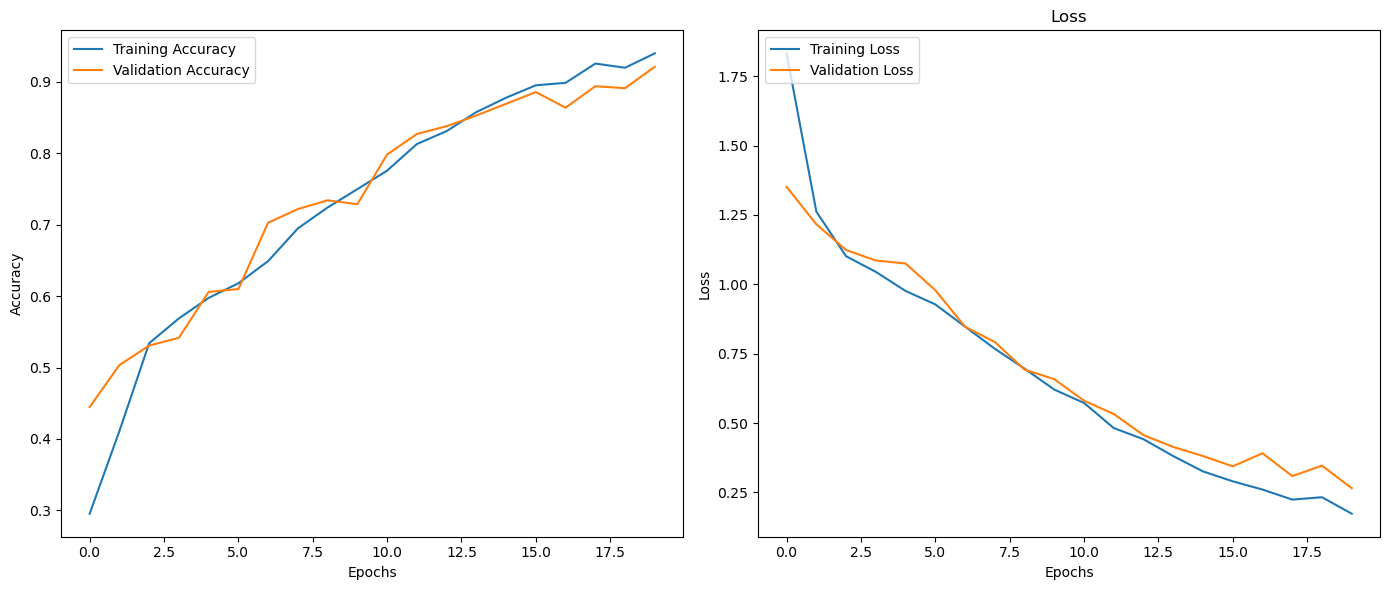

In [29]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc   = history.history['val_accuracy']
val_loss  = history.history['val_loss']

epochs = range(len(train_acc))
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
# Training accuracy v/s valdation accuracy
axes[0].plot(epochs,train_acc,label='Training Accuracy')
axes[0].plot(epochs,val_acc,label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper left')

# Plot training and validation loss
axes[1].plot(epochs,train_loss, label='Training Loss')
axes[1].plot(epochs,val_loss, label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The above plots ensure that our model is learnt the data pattern effectively using above proposed learning rate.
So, we will use this model for future prediction.

# Predictions:

In [35]:
# Load the trained model
Classifiers = load_model('BrainTumorCNNClassifier.keras')

218 0
Image Size:  (150, 150, 3)
Reshaping Image size:  (1, 150, 150, 3)
Original Image: 


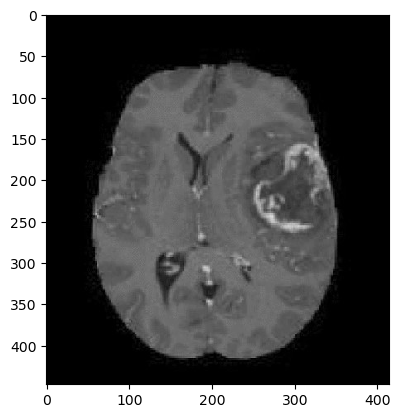

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0.59904414 0.3212558  0.07619313 0.00350694]]
Predicted Tumor type:  glioma_tumor


In [38]:
# Reading images from users
img_path = '/user1/student/mtc/mtc2023/cs2326/Project_Works/btg1.jpg' 
img = cv2.imread(img_path)
print(img.max(),img.min())
img = cv2.resize(img,(150,150))
img_array = np.array(img)
print("Image Size: ",img_array.shape)
img_array = img_array.reshape(1,150,150,3)
print("Reshaping Image size: ",img_array.shape)

# ------------------
load_img = image.load_img(img_path)
plt.imshow(load_img,interpolation='nearest')
print('Original Image: ')
plt.show()

# -------------
pred = Classifiers.predict(img_array)
print(pred)
prediction = labels[pred.argmax()]
print('Predicted Tumor type: ',prediction)